# Resolución EDP (problema INVERSO)

# Ecuación del calor (unidimensional) 🔥
Consideramos el sistema de ecuaciones en derivadas parciales dado por:

\begin{equation}
\begin{cases}
u_t - \alpha \Delta u = f(x,t), & (x,t) \in \Omega \times T, \\[6pt]
u = g(x,t), & (x,t) \in \partial \Omega \times T, \\[6pt]
u(x,t_0) = h(x), & x \in \Omega,
\end{cases}
\end{equation}

donde $u$ es la solución del sistema, $\Omega$ es el dominio espacial, $T$ es el dominio temporal y $\alpha \in \mathbb{R}^+$, un parámetro relacionado con la difusividad térmica del material.

Tomamos $g \equiv 0$,  $h(x) = 4x(1-x)$, y $f \equiv 0$ para tener la EDP conocida como **ecuación del calor unidimensional** (dim $\Omega = 1$) sin fuente de energía externa.

La solución exacta es conocida e igual a $
u(x,t) = \sum_{k=1}^{\infty} \frac{32}{(2k - 1)^3 \pi^3} \, e^{-\alpha \pi^2 (2k - 1)^2 t} \sin((2k - 1)\pi x)$ (hallada usando el método de separación de variables).

A continuación, definimos el código utilizando *TensorFlow*:

In [1]:
import numpy as np                               # Librería de cálculo numérico.
!pip install deepxde                             # Instalación de la librería previamente.
import deepxde as dde                            # Librería de PINNs.
import tensorflow as tf                          # Librería de redes neuronales.
import matplotlib.pyplot as plt                  # Librería de gráficos.
from matplotlib.animation import FuncAnimation   # Función para gráficas animadas.

from mpl_toolkits.mplot3d import Axes3D          # Función para gráficas 3D
from pandas import DataFrame                     # Función para el agrupamiento de datos en tablas.
from google.colab import data_table              # Función para el agrupamiento de datos en tablas dinámicas.
from IPython import display                      # Función para mostrar gráficos en el propio entorno de trabajo.
from itertools import product                    # Librería de herramientas para bucles.

#print("Version de TensorFlow: ", tf.__version__)       # Comprobamos la versión de TensorFlow
#print("GPU disponible: ", tf.test.is_gpu_available())  # Comprobamos que el programa se halla conectado a una GPU.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.9 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


### Parámetros:

In [2]:
# PARÁMETROS Y APLICACIONES DEL PROBLEMA

# Parámetros:
T = [0, 0.2]                                  # Dominio temporal
X = [0, 1]                                    # Dominio espacial

# Parámetro físico (alpha) a extraer del problema y datos observados
alpha_sol = 1.0                               # Valor real del parámetro
param_inicialization = 0.3                    # Valor de inicialización del parámetro desconocido
alpha = dde.Variable(param_inicialization)    # Declaración del parámetro como desconocido e inicialización

# Aplicaciones:

# Residuo de la EDP.
def residuo_edp(x, u):
# Ayuda de la función
  '''
  Determina el residuo (ERROR) de la predicción dada por la red respecto de la EDP
  considerada.

  INPUTS:
    -> X: (list) Datos de entrada introducidos como una matriz cuyas columnas
          se corresponden con cada una de las coordenadas del dominio
          espaciotemporal del problema. En particular, considera la
          **última coordenada** (última columna en la matriz: x[:, -1]) como la que
          corresponde con la variable temporal.
    -> u: (func) Función incógnita del problema.

  OUTPUTS:
    -> Residuo respecto de la EDP
  '''
  # Cálculo de las derivadas parciales que figuran en la expresión de la EDP
  du_t = dde.grad.jacobian(u, x, i=0, j=1)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)

  return du_t - alpha*du_xx

# Aplicación de la condición inicial
def func_inic(x):
  return 4*x[:,0:1]*(1 - x[:,0:1])

# Aplicación de las condiciones de contorno
def func_dirichlet(x):
  return 0.0

# Frontera topológica de las condiciones de Dirichlet
def boundary_dirichlet_izda(x, on_boundary):
  is_on_boundary_D = (
      on_boundary and np.isclose(x[0], X[0])
  )
  return is_on_boundary_D

def boundary_dirichlet_dcha(x, on_boundary):
  is_on_boundary_D = (
      on_boundary and np.isclose(x[0], X[1])
  )
  return is_on_boundary_D

# Frontera topológica de la condición inicial
def boundary_inicial(x, on_initial):
  is_on_boundary = (
      on_initial
      and np.isclose(x[1], T[0])
      and not np.isclose(x[0], X[0])
      and not np.isclose(x[0], X[1])
  )
  return is_on_boundary

# Solución exacta truncada
def func_exact(x):
  trunc_num = 10
  suma = 0
  for k in range(1,trunc_num+1):
    suma = suma + (32/(((2*k-1)**3)*(np.pi**3)))*np.exp(-alpha_sol*(np.pi**2)*((2*k-1)**2)*x[:, 1:])*np.sin((2*k-1)*np.pi*x[:, 0:1])
  return suma

### Número de puntos de colocación:

In [3]:
num_coloc_edp = 200              # Para la EDP
num_coloc_boundary = 100         # Para las condiciones de contorno
# num_coloc_initial = 25         # Para las condiciones iniciales
number_test = num_coloc_edp

### Dominio del problema:

In [4]:
# Definición:
# -RECTÁNGULO
geom = dde.geometry.Rectangle(xmin=[X[0], T[0]], xmax=[X[1], T[1]])
# Usamos módulo de geometría del paquete DeepXde

In [5]:
# Condiciones iniciales y de contorno.
bc_izda = dde.DirichletBC(geom, func_dirichlet, boundary_dirichlet_izda)
bc_dcha = dde.DirichletBC(geom, func_dirichlet, boundary_dirichlet_dcha)
ic = dde.DirichletBC(geom, func_inic, boundary_inicial)

# Observaciones adicionales
num_observ = 55
observ_x = np.vstack((np.linspace(X[0], X[1], num_observ), np.full((num_observ), T[1]))).T
observ_u = dde.icbc.PointSetBC(observ_x, func_exact(observ_x), component=0)

# Agrupación de todos los datos acerca del problema
data = dde.data.TimePDE(
    geom,
    residuo_edp,
    [bc_izda, bc_dcha, ic, observ_u],
    anchors=observ_x,
    num_domain=num_coloc_edp,
    num_boundary=num_coloc_boundary,
    num_test = number_test,
    solution = func_exact)

In [6]:
# Muestra el conjunto de datos de entrenamiento.

# print("El conjunto de datos de entrenamiento es: \n {}".format(data.train_x_all.T))

print("El conjunto de datos de entrenamiento es:")
#datos_entrenamiento = np.array([data.train_x_all.T[0], data.train_x_all.T[1]]).T
#tabladatos_entrenamiento = DataFrame(datos_entrenamiento, columns = ["x_k", "t_k"])
#data_table.DataTable(tabladatos_entrenamiento, include_index=True, num_rows_per_page=10)

El conjunto de datos de entrenamiento es:


In [7]:
# Muestra el conjunto de datos de test.

#print("El conjunto de datos de test es: \n {}".format(data.test_x.T))

print("El conjunto de datos de test es:")
#datos_test = np.array([data.test_x.T[0], data.test_x.T[1]]).T
#tabladatos_test = DataFrame(datos_test, columns = ["x_k", "t_k"])
#data_table.DataTable(tabladatos_test, include_index=True, num_rows_per_page=10)

El conjunto de datos de test es:


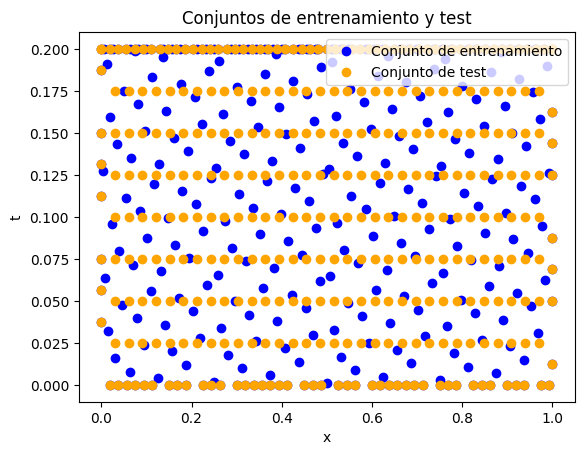

In [8]:
# Gráfico de los conjuntos de entrenamiento y test
fig, ax = plt.subplots()

ax.plot(data.train_x_all.T[0], data.train_x_all.T[1], "o", color = "blue", label="Conjunto de entrenamiento")
#ax.plot(validating_set.T[0], validating_set.T[1], "ro", label="Conjunto de validación")
ax.plot(data.test_x.T[0], data.test_x.T[1], "o", color = "orange", label="Conjunto de test")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Conjuntos de entrenamiento y test")
ax.legend(loc = "upper right")
plt.show()

### Hiperparámetros:

In [9]:
capas = [2] + [50] * 4 + [1]       # 2 elementos en la capa de entrada, 4 capas ocultas de 50 neuronas cada una y una quinta con una sola neurona (capa de salida con un único elemento)
func_activacion = "tanh"           # Función de activación "tanh"
learning_rate = 1e-3               # Tasa de aprendizaje
iters = 10100                      # Número de iteraciones del método de optimización
tamanio_lotes = 500                # Tamaño de los "lotes" usados en el entrenamiento
initializer = "Glorot uniform"     # Inicializador de pesos (de acuerdo a una distribución de Glorot)

### Construcción modelo PINN:

In [10]:
# Construcción de la red neuronal prealimentada (FFNN) que constituye la PINN
net = dde.maps.FNN(capas, func_activacion, initializer)

# Definición del modelo completo
model = dde.Model(data, net)

### Entrenamiento red neuronal:

*   Implementación sobre el modelo de una cierta función de pérdida (MSE)
*   Implementación de algún método de optimización

In [11]:
# Durante el entrenamiento, se incluye el parámetro a determinar alpha como "variable externa"
# (y se muestra el valor que se va adquiriendo de este cada 1000 iteraciones)

# DOBLE ENTRENAMIENTO (reduce errores de entrenamiento y de generalización):
# Callback para mostrar valor de alpha cada 1000 iteraciones
variable = dde.callbacks.VariableValue(alpha, period=1000)
# Primer entrenamiento empleando el método Adam.
model.compile("adam", lr=learning_rate, loss='MSE', external_trainable_variables=alpha)
variable = dde.callbacks.VariableValue(alpha, period=1000)#,filename="variables.dat")  # Mostrar el valor adquirido de alpha cada 1000 iteraciones.
loss_history, train_state = model.train(iterations=iters, batch_size = tamanio_lotes, callbacks=[variable])

# Segundo entrenamiento empleando el método L-BFGS.
model.compile("L-BFGS", loss='MSE', external_trainable_variables=alpha)
variable = dde.callbacks.VariableValue(alpha, period=1000)#,filename="variables.dat")  # Mostrar el valor adquirido de alpha cada 1000 iteraciones.
loss_history, train_state = model.train(batch_size = tamanio_lotes, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.421716 s

'compile' took 1.114239 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.83e-04, 4.36e-06, 8.36e-03, 6.02e-01, 2.17e-02]    [1.66e-04, 4.36e-06, 8.36e-03, 6.02e-01, 2.17e-02]    []  
0 [3.00e-01]
1000      [1.26e-03, 7.10e-04, 3.16e-03, 2.25e-03, 8.04e-03]    [7.84e-04, 7.10e-04, 3.16e-03, 2.25e-03, 8.04e-03]    []  
1000 [6.33e-01]
2000      [7.90e-03, 2.63e-04, 1.49e-03, 1.52e-03, 4.24e-03]    [7.61e-03, 2.63e-04, 1.49e-03, 1.52e-03, 4.24e-03]    []  
2000 [7.53e-01]
3000      [9.27e-04, 2.12e-04, 7.88e-04, 7.42e-04, 1.30e-03]    [7.30e-04, 2.12e-04, 7.88e-04, 7.42e-04, 1.30e-03]    []  
3000 [8.17e-01]
4000      [4.23e-04, 1.23e-04, 2.62e-04, 3.24e-04, 6.30e-04]    [4.24e-04, 1.23e-04, 2.62e-04, 3.24e-04, 6.30e-04]    []  
4000 [8.62e-01]
5000      [3.94e-04, 9.57e-05, 1.51e-04, 2.45e-0

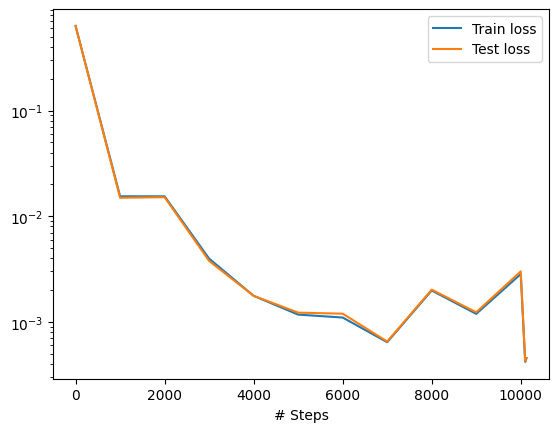

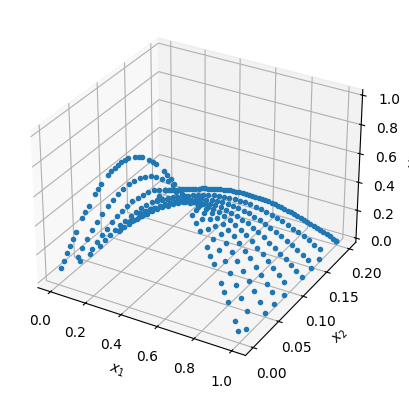

In [12]:
# Gráficas de los errores de entrenamiento y generalización
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

### Predicción sobre la solución del problema:

Predicciones realizadas por la PINN para algunos datos de entrada elegidos uniformemente y su comparación con la solución exacta (conocida)

In [13]:
# Mallado uniforme sobre el dominio espaciotemporal
n_ptos_x = 100                        # Número de puntos en el eje espacial
n_ptos_t = 100                        # Número de puntos en el eje temporal
xx=np.linspace(X[0],X[1],n_ptos_x)    # Partición del dominio espacial
tt=np.linspace(T[0],T[1],n_ptos_t)    # Partición del dominio temporal

# Extración de los elementos del producto cartesiano que conforma el mallado (ordenado primero según tt y luego según xx).
Xx, Tt = np.meshgrid(xx, tt)

Instante: 0.0 	
[Mín(u), máx(u)] = [0.03118884563446045, 1.015928030014038]


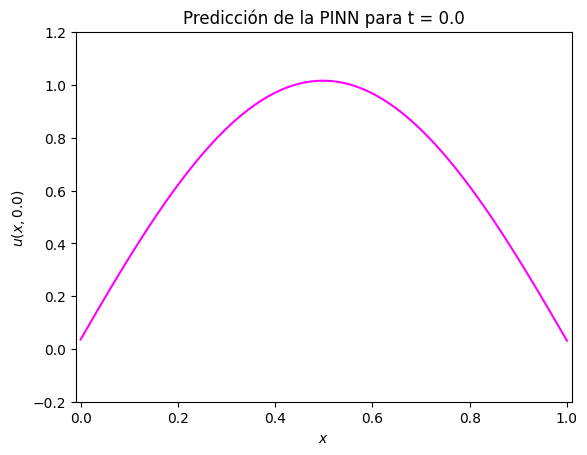

Instante: 0.0202020202020202 	
[Mín(u), máx(u)] = [0.015419352799654007, 0.8468716144561768]


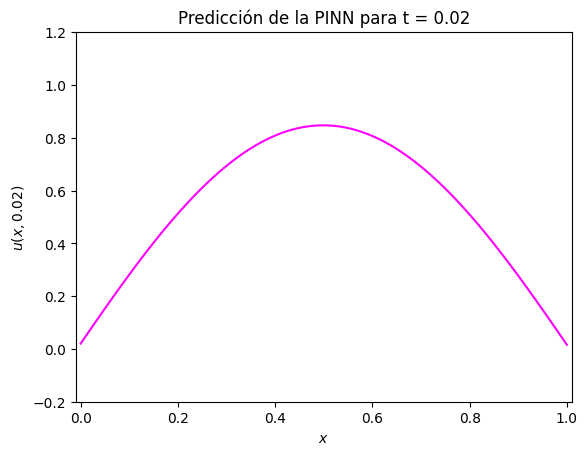

Instante: 0.0404040404040404 	
[Mín(u), máx(u)] = [0.004245169460773468, 0.7041356563568115]


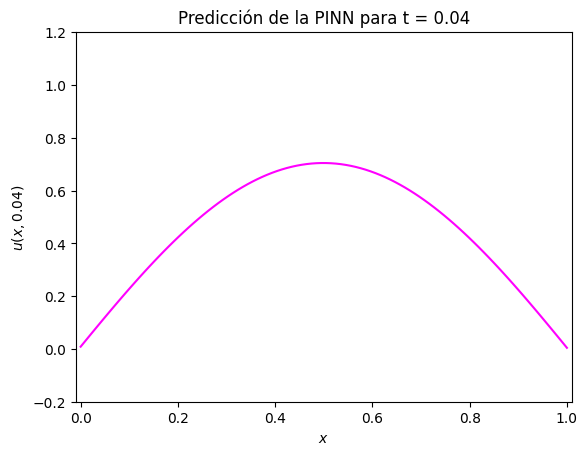

Instante: 0.06060606060606061 	
[Mín(u), máx(u)] = [-0.0031960755586624146, 0.5839005708694458]


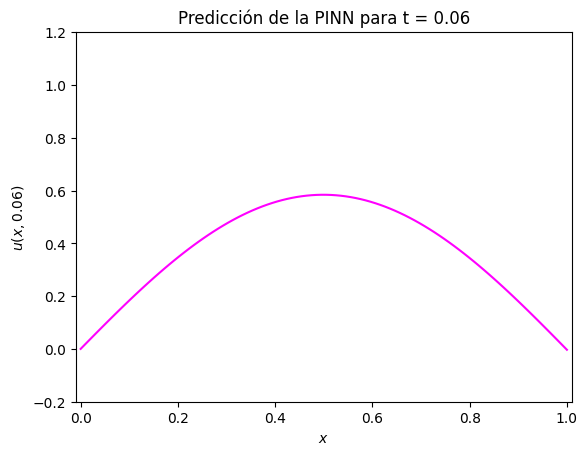

Instante: 0.0808080808080808 	
[Mín(u), máx(u)] = [-0.007627606391906738, 0.4827834367752075]


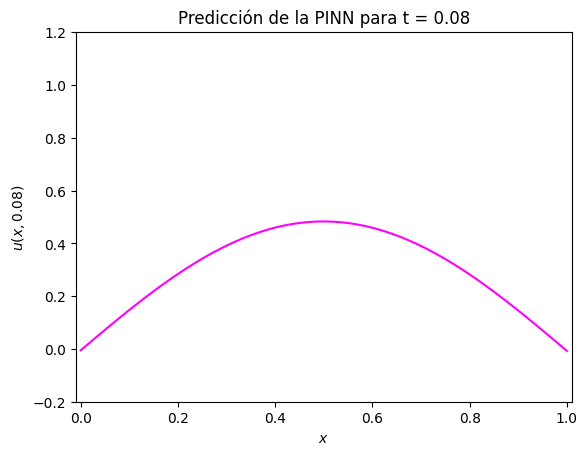

Instante: 0.10101010101010101 	
[Mín(u), máx(u)] = [-0.009655453264713287, 0.3979949355125427]


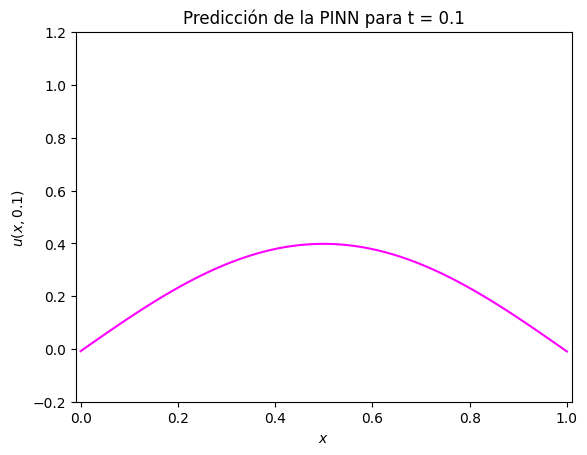

Instante: 0.12121212121212122 	
[Mín(u), máx(u)] = [-0.00977998971939087, 0.32722634077072144]


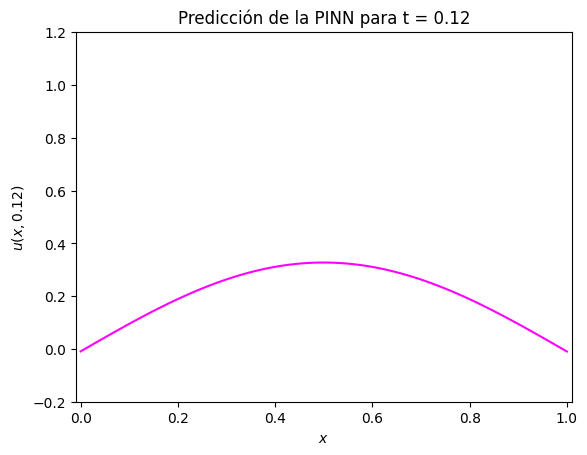

Instante: 0.1414141414141414 	
[Mín(u), máx(u)] = [-0.008411906659603119, 0.2685036063194275]


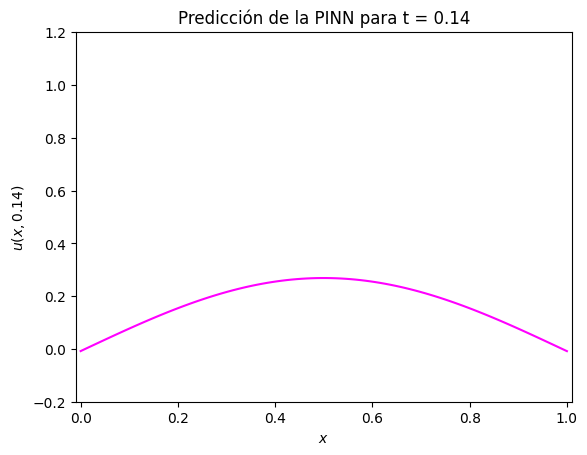

Instante: 0.1616161616161616 	
[Mín(u), máx(u)] = [-0.005892626941204071, 0.22009192407131195]


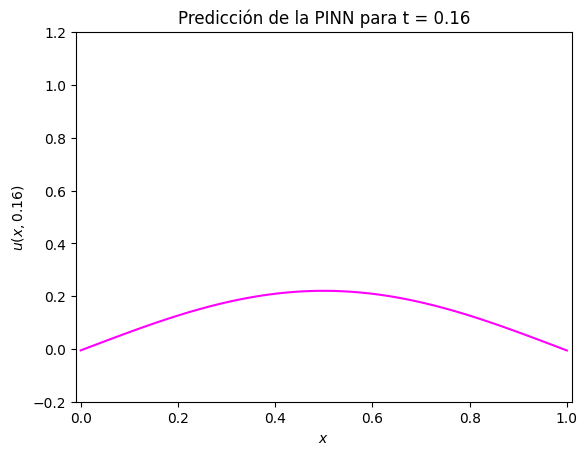

Instante: 0.18181818181818182 	
[Mín(u), máx(u)] = [-0.00251040980219841, 0.18044288456439972]


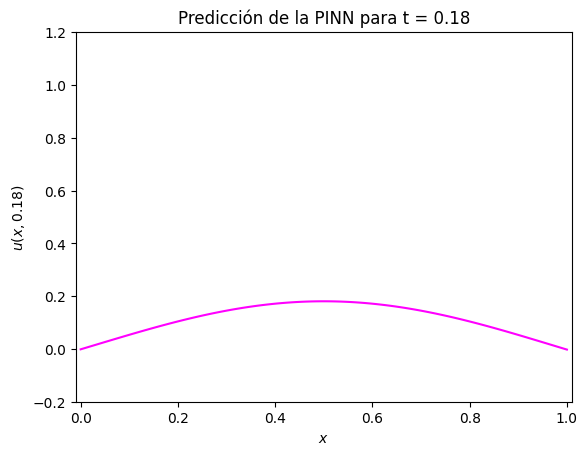

In [14]:
# Gráfico de la predicción de la PINN por instantes de tiempo

num_inst = 10                                                            # Número de instantes de tiempo considerados
t_list = [tt[int(inst*(len(tt)/num_inst))] for inst in range(num_inst)]  # Instantes de tiempo considerados dentro del mallado anterior

for t in t_list:
  print("Instante:", t, "\t")                                            # Impresión en pantalla

  # Restricción del mallado correspondiente al instante considerado
  x_repre, t_repre = np.meshgrid(xx, t)
  XT_list = np.vstack((x_repre.ravel(), t_repre.ravel())).T

  # Predicción realizada por la PINN
  U = model.predict(XT_list).T
  print(f"[Mín(u), máx(u)] = [{min(U[0])}, {max(U[0])}]")                # Impresión en pantalla de los valores mínimo y máximo de la predicción

  # Representación gráfica
  fig, ax = plt.subplots()
  ax.plot(x_repre[0],U[0], color="fuchsia")

  # Instrucciones decorativas del gráfico
  ax.set_title("Predicción de la PINN para t = "+str(round(t,2)))
  ax.set_xlabel("$x$")
  ax.set_ylabel("$u(x,$"+str(round(t,2))+")")
  ax.set_xlim(-0.01,1.01)
  ax.set_ylim(-0.2,1.2)

  plt.show()                                                             # Gráfico.

In [15]:
# Animación de la predicción de la PINN sobre el mallado uniforme

XT_list = []
U = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos

# Representación gráfica
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico
ax.set_title("Predicción de la PINN")
ax.set_xlabel("$x$")
ax.set_ylabel("$u_θ(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.2,1.2)

line, = ax.plot(Xx[0],U[0][0], color="fuchsia")

def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(U[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación
display.display(html)
plt.close()

#anim.save('PINNEj2prediccion.mp4', fps=30)     # Se almacena la animación

In [16]:
# Animación de la solución exacta sobre el mallado uniforme

sol_exact = []
for i in range(len(Xx)):
  sol_exact.append(func_exact(XT_list[i]).T)        # Predicción sobre los puntos

# Representación gráfica
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico
ax.set_title("Solución exacta")
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.2,1.2)

line, = ax.plot(Xx[0],sol_exact[0][0], color="green")

def animate_func(i):
  line.set_xdata(Xx[i])
  line.set_ydata(sol_exact[i][0])
  return line,

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación
display.display(html)
plt.close()

#anim.save('PINNEj2solexacta.mp4', fps=30)     # Se almacena la animación

### Comparación entre la solución exacta y la predicción de la PINN:

In [17]:
# Animación de la comparación entre la predicción de la PINN y la solución exacta sobre el mallado uniforme

XT_list = []
U = []
sol_exact = []
for i in range(len(Xx)):
  XT_list.append(np.vstack((Xx[i],Tt[i])).T)   # Lista de puntos del mallado
  U.append(model.predict(XT_list[i]).T)        # Predicción sobre los puntos
  sol_exact.append(func_exact(XT_list[i]).T)   # Solución sobre los puntos

# Representación gráfica
fig, ax = plt.subplots()

# Instrucciones decorativas del gráfico
ax.set_title("Comparación entre la predicción de la PINN y la solución exacta.")
ax.set_xlabel("$x$")
ax.set_ylabel("$u(x,t)$")
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.2,1.2)

line1, = ax.plot(Xx[0],U[0][0], color="fuchsia")
line2, = ax.plot(Xx[0],sol_exact[0][0], color="green")

def animate_func(i):
  line1.set_xdata(Xx[i])
  line1.set_ydata(U[i][0])
  line2.set_xdata(Xx[i])
  line2.set_ydata(sol_exact[i][0])
  return line1, line2

anim = FuncAnimation(fig, animate_func, frames=len(tt), interval=50)

# Conversión de la animación a vídeo
video = anim.to_html5_video()
html = display.HTML(video)

# Se muestra la animación
display.display(html)
plt.close()

#anim.save('PINNEj2comparacion.mp4', fps=30)     # Se almacena la animación

### Error entre la predicción y la solución exacta:

In [18]:
# Cálculo del error en norma L^2(Ω)
from scipy.integrate import quad

error = []
for t in tt:
  error.append(quad(lambda x: (model.predict([[x,t]])[0,0] - func_exact(np.array([[x,t]]))[0,0])**2,X[0],X[1]))

error = np.array(error).T

errorL2 = error[0]
error_aprox_integr = error[1]

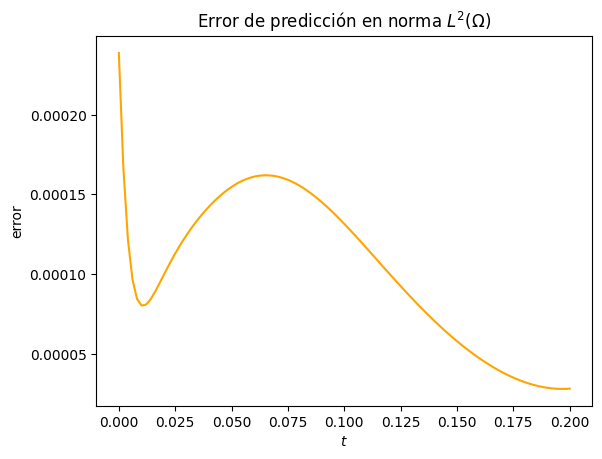

In [19]:
# Representación gráfica del error en norma L^2(Ω)
fig, ax = plt.subplots()
ax.plot(tt,errorL2, color="orange")

# Instrucciones decorativas del gráfico
ax.set_title("Error de predicción en norma $L^2(\Omega)$")
ax.set_xlabel("$t$")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)

plt.show()                            # Gráfico

 Empleando la función `quad` del módulo `spicy.integrate` se ha calculado la integral sobre $\Omega$ para calcular el error en norma $L^2(\Omega)$ (ver la [documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)).

Representación del error absoluto con respecto a la integral exacta.

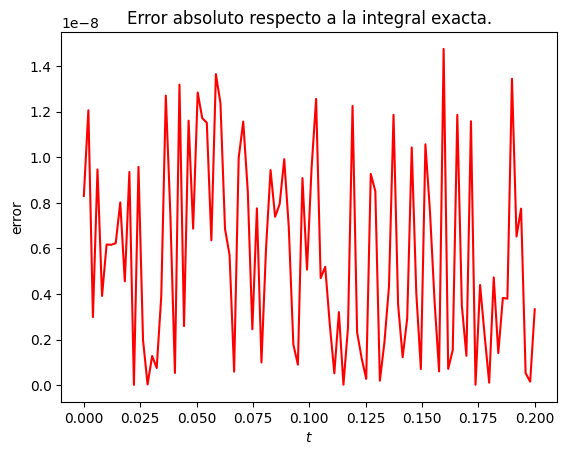

In [20]:
# Representación gráfica del error de cuadratura
fig, ax = plt.subplots()
ax.plot(tt,error_aprox_integr, color="red")

# Instrucciones decorativas del gráfico
ax.set_title("Error absoluto respecto a la integral exacta.")
ax.set_xlabel("$t$")
ax.set_ylabel("error")
ax.set_xlim(T[0]-0.01,T[1]+0.01)
#ax.set_ylim(-1e-8,7.5e-6)

plt.show()                            # Gráfico